1. Добавить MA фичи
2. Добавить другие фичи


In [38]:
import pandas as pd
import numpy as np
import catboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import scipy

from tqdm import tqdm
from warnings import filterwarnings
from IPython.display import display

filterwarnings("ignore")

In [44]:
class ModelBuilderUtils:
    def __init__(self):
        self.metrics = {"MAE": None, "RMSE": None, "MAPE": None, "R2": None}

    def load_data(self, path: str = "./data/BST_DataSet.xlsx"):
        df = pd.read_excel(path, parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')

        self.columns_to_nums = dict(zip(df.columns, np.arange(len(df.columns), dtype=int)))
        self.nums_to_columns = dict(zip(np.arange(len(df.columns), dtype=int), df.columns))

        df = df.rename(columns=self.columns_to_nums, inplace=False)

        df['target'] = df[0]
        df = df.drop([0], axis=1, inplace=False)

        return df

    def enreach_data(self, df):
        pass

    def split(self, df):
        df1 = df['target']
        train_ts = df1[df1.index < '2017-01-01']
        test_ts = df1[df1.index >= '2017-01-01']
        return train_ts, test_ts

    def score_model(self, y_trues, y_preds):
        self.metrics["MAE"] = int(mean_absolute_error(y_trues, y_preds))
        self.metrics["MAPE"] = mean_absolute_percentage_error(y_trues, y_preds)
        self.metrics["RMSE"] = int(mean_squared_error(y_trues, y_preds, squared=False))
        self.metrics["R2"] = r2_score(y_trues, y_preds)

    def display_predictions(self, timeseries, predict):
        plt.figure(dpi=150)
        plt.figure(figsize=(16, 6))
        plt.grid()
        plt.plot(timeseries, color="blue", label="true")
        plt.plot(predict, color="green", label="predictions")
        plt.legend(loc="upper left")
        plt.show()

In [45]:
class ModelBuilderFeatureExtractor:
    def __init__(self):
        pass

    def select_period(self, timeseries, model_idx):
        return timeseries[-(self.window + model_idx):].values

    def generate_monthly_mean(self, timeseries):
        tmp = pd.DataFrame(timeseries)
        tmp['month'] = tmp.index.month
        monthly_mean = tmp.groupby(['month'])['target'].mean()
        self.monthly_mean = monthly_mean

    def extact_monthly_sin(self, timeseries):
        f = lambda x: np.sin(x / 3.82)
        return pd.Series(list(map(f, timeseries.index.month)), index=timeseries.index)

    def extract_monthly_mean(self, timeseries):
        res = []
        for i in timeseries.index:
            res.append(self.monthly_mean.loc[i.month])
        return pd.Series(res, index=timeseries.index)

    def generate_features(self, timeseries):
        f1 = self.extact_monthly_sin(timeseries)
        f2 = self.extract_monthly_mean(timeseries)
        return np.c_[f1, f2]

    def extract_ma_features(self, timeseries):
        return timeseries.rolling(self.window, closed="left").mean().bfill()

In [46]:
class ModelBuilder(ModelBuilderUtils, ModelBuilderFeatureExtractor):
    def __init__(self, window: int = 8):
        super().__init__()
        ModelBuilderFeatureExtractor.window = window

        self.window = window
        self.model_count = 12  # number of days to predict
        self.add_features = True  # add features

    def build_datasets(self, timeseries):
        datasets = [float('inf')] * self.model_count

        for i in range(self.model_count):
            X = np.lib.stride_tricks.sliding_window_view(timeseries, i + self.window)[:-1]  # base
            y = timeseries[i + self.window:]

            if self.add_features:
                features = self.generate_features(y)
                X = np.c_[X, features]

            datasets[i] = (X, y)

        assert len(datasets) == self.model_count

        return datasets

    def train_models(self, datasets):
        models = [float('inf')] * self.model_count

        for i in tqdm(range(self.model_count)):
            model = catboost.CatBoostRegressor(n_estimators=1000, verbose=False, allow_writing_files=False,
                                               loss_function='RMSE')
            model.fit(*datasets[i])
            models[i] = model

        assert len(models) == len(datasets)

        return models

    def predict(self, timeseries, models):  # pass train_ts as init

        for i in range(self.model_count):
            row = self.select_period(timeseries, i)

            if self.add_features:
                features = self.generate_features(
                    pd.Series([None], index=[timeseries.index[-1] + pd.DateOffset(months=1)]))
                row = np.append(row, features.squeeze())

            predict = models[i].predict(row)
            predict = pd.Series([predict], index=[timeseries.index[-1] + pd.DateOffset(months=1)])
            timeseries = pd.concat([timeseries, predict])

        return timeseries[-self.model_count:]

100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


<Figure size 900x600 with 0 Axes>

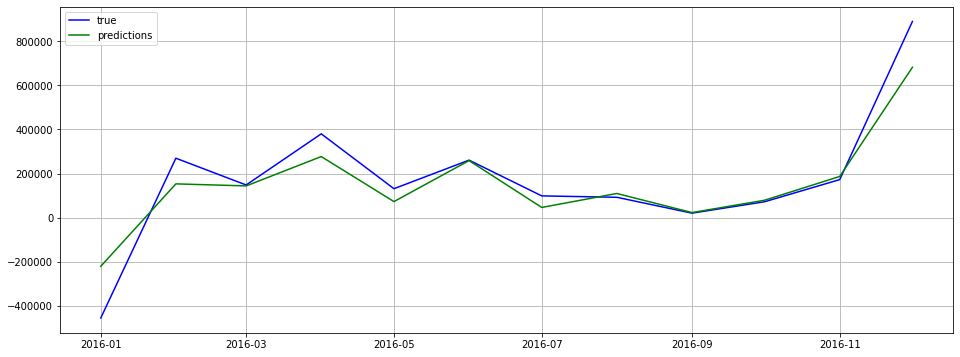

,MAE,RMSE,MAPE,R2
0,68281,103631,0.246788,0.872976


In [47]:
class Model(ModelBuilder):
    def __init__(self):
        super().__init__()
        pass

    def main(self, inference=False):
        df = self.load_data()

        train_ts, test_ts = self.split(df)
        self.generate_monthly_mean(train_ts)

        if not inference:
            _ = pd.Series.copy(train_ts)
            train_ts = pd.Series.copy(_[:-self.model_count])
            test_ts = pd.Series.copy(_[-self.model_count:])
            self.generate_monthly_mean(train_ts)

        datasets = self.build_datasets(train_ts)
        models = self.train_models(datasets)
        preds = round(self.predict(train_ts, models))

        if inference:
            plt.figure(dpi=150)
            plt.figure(figsize=(16, 6))
            plt.grid()
            plt.plot(train_ts)
            plt.plot(preds)
            plt.show()
            preds.to_csv("./output/predictions.csv", index=True)

        if not inference:
            self.score_model(test_ts, preds)
            self.display_predictions(test_ts, preds)
            display(pd.DataFrame(self.metrics, index=[0]))


model = Model()
model.main()

100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


<Figure size 900x600 with 0 Axes>

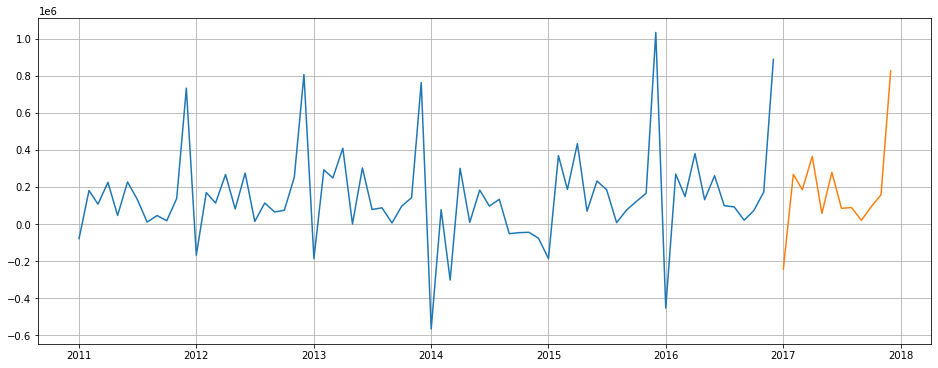

In [48]:
model.main(inference=True)